In [1]:
from module import Module, Linear
from loss import Loss, MSELoss, LogSoftMax
from activation import TanH, Sigmoide
from sequentiel import Sequentiel
from conv import Conv1D
from maxpool import MaxPool1D
from flatten import Flatten
from optim import Optim, creer_mini_batches
from relu import Relu
import numpy as np
import matplotlib.pyplot as plt
import h5py
from softmax import SoftMax
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from time import time

# TEST 1: classification binaire avec les chiffres manuscrits
On va isoler deux classes(par exemple 1 et 9) parmi les 10 classe et essayer d'entrainer notre réseau de neurone pour discriminer les classes

In [2]:
with h5py.File('../usps.h5', 'r') as hf:
    train = hf.get('train')
    X_tr = train.get('data')[:]
    y_tr = train.get('target')[:]
    test = hf.get('test')
    X_te = test.get('data')[:]
    y_te = test.get('target')[:]
print("Taille des données en train: ", X_tr.shape)
print("Taille des données en test: ", X_te.shape)
print("Classe des données en train: ", np.unique(y_tr))
print("Classe des données en test: ", np.unique(y_te))
print("Valeurs des pixels d'une image: ",np.unique(X_tr[0]))
print("Intervalles de valeur des données: ",np.unique(np.min(X_tr, axis=1))," à ", np.unique(np.max(X_tr, axis=1)))

Taille des données en train:  (7291, 256)
Taille des données en test:  (2007, 256)
Classe des données en train:  [0 1 2 3 4 5 6 7 8 9]
Classe des données en test:  [0 1 2 3 4 5 6 7 8 9]
Valeurs des pixels d'une image:  [0.         0.0025     0.00400001 0.0045     0.00650001 0.01300001
 0.01949999 0.02500001 0.02849999 0.02900001 0.03099999 0.03749999
 0.04750001 0.0485     0.058      0.08399999 0.088      0.1015
 0.1275     0.1385     0.14250001 0.143      0.15849999 0.1615
 0.18450001 0.185      0.2175     0.225      0.25849998 0.263
 0.274      0.2805     0.2855     0.29500002 0.37150002 0.4075
 0.4165     0.419      0.44550002 0.4625     0.5135     0.534
 0.546      0.55       0.5565     0.5675     0.5725     0.592
 0.6095     0.639      0.64849997 0.65       0.652      0.6535
 0.654      0.6635     0.6705     0.6775     0.741      0.7425
 0.768      0.77       0.77250004 0.781      0.8205     0.8275
 0.8535     0.8765     0.889      0.896      0.906      0.9065
 0.9115     0.9125  

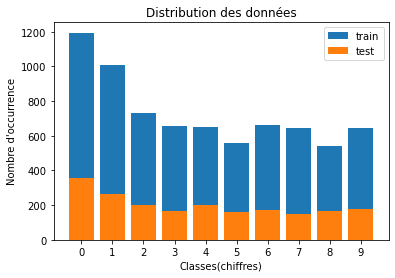

In [3]:
stats_tr = np.unique(y_tr, return_counts=True)
stats_te = np.unique(y_te, return_counts=True)
plt.figure()
plt.bar(stats_tr[0].astype(str), stats_tr[1])
plt.bar(stats_te[0].astype(str), stats_te[1])
plt.legend(labels=["train", "test"])
plt.title("Distribution des données")
plt.ylabel("Nombre d'occurrence")
plt.xlabel("Classes(chiffres)")
plt.savefig("../dist_data.jpg")

In [3]:
def get_usps(l,datax,datay):
    if type(l)!=list:
        resx = datax[datay==l,:]
        resy = datay[datay==l]
        return resx,resy
    tmp =   list(zip(*[get_usps(i,datax,datay) for i in l]))
    tmpx,tmpy = np.vstack(tmp[0]),np.hstack(tmp[1])
    return tmpx,tmpy

def show_usps(data):
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")

In [4]:
def score(predict_fn, net, X, y):
    yhat = predict_fn(net, X)
    return (yhat==y).mean()*100

def plot_loss(loss_data, title=""):
    plt.figure()
    plt.plot(loss_data)
    plt.xlabel("Epoch")
    plt.ylabel("Cout")
    plt.title(title)
    plt.legend()
    plt.savefig("../loss_conv1_multi.jpg")
    plt.show()

In [17]:
MAX_ITER = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 20

POS = 1
NEG = 9
# architecture du reseau de neurone utilisé
netBin = Sequentiel([
    Linear(X_tr.shape[1], 64),
    Relu(),
    # Sigmoide(),
    Linear(64, 1),
    Sigmoide()
    # Relu()
])

In [18]:
optimBin = Optim(netBin, MSELoss(), eps=LEARNING_RATE)
def trainBinary(X, y):
    train_loss = []
    start = time()
    for epoch in range(MAX_ITER):
        allbatches = creer_mini_batches(X, y.reshape(-1, 1), BATCH_SIZE) # création de batch
        current_loss = 0
        for datax, labels in allbatches:
            optimBin.step(datax, labels.astype(int))
            current_loss += optimBin.loss_value
        train_loss.append(current_loss/len(allbatches))

        if (epoch+1)%10==0:
            print("Epoch {}/{} avec un coût de {:.3f}".format(epoch+1, MAX_ITER, current_loss/len(allbatches)))
    print("Fin...")
    runTime = round((time()-start), 3)
    return train_loss, runTime

def predictBinary(net, X):
    out = net.forward(X)
    return np.where(out<0.5, 0, 1).reshape(-1,)


In [19]:
# preparer les données

bin_x_tr, bin_y_tr = get_usps([POS, NEG], X_tr, y_tr)
bin_x_te, bin_y_te = get_usps([POS, NEG], X_te, y_te)
bin_y_tr = np.where(bin_y_tr==POS, 1, 0).reshape(-1,1)
bin_y_te = np.where(bin_y_te==POS, 1, 0).reshape(-1,1)

In [20]:
train_loss_bin, runTime = trainBinary(bin_x_tr, bin_y_tr)
print(runTime)

Epoch 10/100 avec un coût de 0.027
Epoch 20/100 avec un coût de 0.017
Epoch 30/100 avec un coût de 0.011
Epoch 40/100 avec un coût de 0.009
Epoch 50/100 avec un coût de 0.008
Epoch 60/100 avec un coût de 0.007
Epoch 70/100 avec un coût de 0.006
Epoch 80/100 avec un coût de 0.006
Epoch 90/100 avec un coût de 0.006
Epoch 100/100 avec un coût de 0.007
Fin...
10.093


No handles with labels found to put in legend.


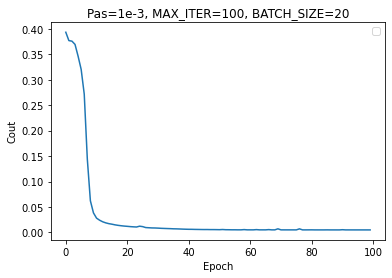

In [189]:
plot_loss(train_loss_bin, title = "Pas="+str(LEARNING_RATE)+", MAX_ITER="+str(MAX_ITER)+" et Batch_Size="+str(BATCH_SIZE))

In [20]:
print("Original values:")
print(bin_y_te[:20].reshape(-1,)) # pour l'apprentissage il a un shuffle au niveau de la création des batch
print("Predicted values:")
print(predictBinary(optimBin.net, bin_x_te[:20]))
print("Score: ", score(predictBinary, optimBin.net, bin_x_te[:20], bin_y_te[:20].reshape(-1,)))

Original values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Predicted values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Score:  100.0


In [22]:
pred_y = predictBinary(optimBin.net, bin_x_te)
print(classification_report(bin_y_te, pred_y, target_names=['9', '1']))

              precision    recall  f1-score   support

           9       0.96      0.97      0.97       177
           1       0.98      0.97      0.98       264

    accuracy                           0.97       441
   macro avg       0.97      0.97      0.97       441
weighted avg       0.97      0.97      0.97       441



In [23]:
f1_score(bin_y_te, pred_y)

0.9771863117870723

<ipython-input-85-9f3cb420e1ab>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(['']+labels)
<ipython-input-85-9f3cb420e1ab>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['']+labels)


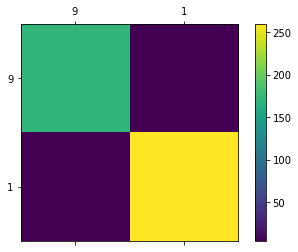

In [85]:
labels = [str(NEG), str(POS)]
  
figure = plt.figure()
axes = fi100gure.add_subplot(111)
  
# using the matshow() function 
caxes = axes.matshow(confusion_matrix(bin_y_te, pred_y), interpolation ='nearest')
figure.colorbar(caxes)
  
axes.set_xticklabels(['']+labels)
axes.set_yticklabels(['']+labels)

plt.savefig("../matrice_conf_91_NN2.jpg")
plt.show()

# TEST 2: classification multiclasse sur des chiffres manuscrits

In [65]:
MAX_ITER = 150
LEARNING_RATE = 5e-3
BATCH_SIZE = 50
# architecture du reseau de neurone utilisé
netMulti = Sequentiel([
    Linear(X_tr.shape[1], 64),
    # Relu(),
    # Linear(100,64),
    Sigmoide(),
    Linear(64, 10)
])

In [66]:
optimMulti = Optim(netMulti, LogSoftMax(), eps=LEARNING_RATE)
def trainMulti(X, y):
    train_loss = []
    start = time()
    for epoch in range(MAX_ITER):
        allbatches = creer_mini_batches(X, y.reshape(-1, 1), BATCH_SIZE) # création de batch
        current_loss = 0
        for datax, labels in allbatches:
            optimMulti.step(datax, labels.astype(int).reshape(-1,))
            current_loss += optimMulti.loss_value
        train_loss.append(current_loss/len(allbatches))

        if (epoch+1)%10==0:
            print("Epoch {}/{} avec un coût de {:.3f}".format(epoch+1, MAX_ITER, current_loss/len(allbatches)))
    print("Fin...")
    runTime = round((time()-start), 3)
    return train_loss, runTime

def predictMulti(net, X):
    s = SoftMax()
    yhat = s.forward(net.forward(X)) # predicted y between [0-1]
    return np.argmax(yhat, axis=1) # recupérer les indices des plus grandes probabilités


In [67]:
train_loss, runTime = trainMulti(X_tr, y_tr)
print(runTime)

Epoch 10/150 avec un coût de 0.180
Epoch 20/150 avec un coût de 0.116
Epoch 30/150 avec un coût de 0.083
Epoch 40/150 avec un coût de 0.061
Epoch 50/150 avec un coût de 0.047
Epoch 60/150 avec un coût de 0.037
Epoch 70/150 avec un coût de 0.029
Epoch 80/150 avec un coût de 0.024
Epoch 90/150 avec un coût de 0.020
Epoch 100/150 avec un coût de 0.017
Epoch 110/150 avec un coût de 0.014
Epoch 120/150 avec un coût de 0.013
Epoch 130/150 avec un coût de 0.011
Epoch 140/150 avec un coût de 0.010
Epoch 150/150 avec un coût de 0.009
Fin...
39.739


No handles with labels found to put in legend.


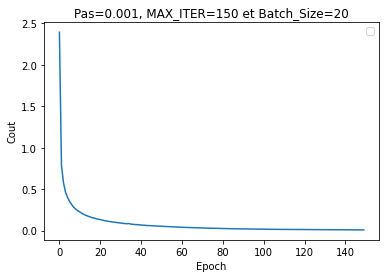

In [13]:
plot_loss(train_loss, title = "Pas="+str(LEARNING_RATE)+", MAX_ITER="+str(MAX_ITER)+" et Batch_Size="+str(BATCH_SIZE))

In [30]:
print(predictMulti(optimMulti.net, X_te[:20]))
print(y_te[:20])

[9 6 3 4 6 0 0 0 6 9 6 2 3 8 0 3 1 4 9 6]
[9 6 3 6 6 0 0 0 6 9 6 2 2 4 0 3 1 6 9 6]


In [68]:
pred_y_multi =  predictMulti(optimMulti.net, X_te)
print(classification_report(y_te, pred_y_multi))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97       359
           1       0.99      0.95      0.97       264
           2       0.92      0.89      0.91       198
           3       0.86      0.90      0.88       166
           4       0.87      0.92      0.89       200
           5       0.91      0.91      0.91       160
           6       0.96      0.95      0.96       170
           7       0.91      0.92      0.92       147
           8       0.92      0.88      0.90       166
           9       0.94      0.95      0.94       177

    accuracy                           0.93      2007
   macro avg       0.92      0.92      0.92      2007
weighted avg       0.93      0.93      0.93      2007



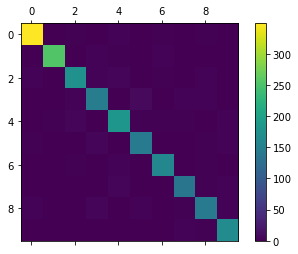

In [34]:
  
figure = plt.figure()
axes = figure.add_subplot(111)
  
# using the matshow() function 
caxes = axes.matshow(confusion_matrix(y_te, pred_y_multi), interpolation ='nearest')
figure.colorbar(caxes)

plt.savefig("../matrice_conf_multi_NN.jpg")
plt.show()

In [37]:
print("Original values:")
print(y_te[:20])
print("Predicted values:")
print(predictMulti(optimMulti.net, X_te[:20]))
print("Score: ", score(predictMulti, optimMulti.net, X_te[:20], y_te[:20]))

Original values:
[9 6 3 6 6 0 0 0 6 9 6 2 2 4 0 3 1 6 9 6]
Predicted values:
[9 6 3 0 6 0 0 0 6 9 6 2 2 4 0 3 1 2 9 6]
Score:  90.0


In [57]:
MAX_ITER = 3
LEARNING_RATE = 1e-3
BATCH_SIZE = 30
DEBUG_STEP = 1
# architecture du reseau de neurone convolutionnel utilisé
cnn = Sequentiel([
    Conv1D(4, 1, 32, 4),
    MaxPool1D(2, 2),
    Flatten(),
    Linear(1024, 100),
    Relu(),
    Linear(100, 10)
])
optimCNN = Optim(cnn, LogSoftMax(), eps=LEARNING_RATE)

In [58]:
def trainCNN(X, y):
    train_loss = []
    start = time()
    for epoch in range(MAX_ITER):
        allbatches = creer_mini_batches(X, y.reshape(-1, 1), BATCH_SIZE) # création de batch
        current_loss = 0
        for datax, labels in allbatches:
            optimCNN.step(datax, labels.astype(int).reshape(-1,))
            current_loss += optimCNN.loss_value
        train_loss.append(current_loss/len(allbatches))

        if (epoch+1)%DEBUG_STEP==0:
            print("Epoch {}/{} avec un coût de {:.3f}".format(epoch+1, MAX_ITER, current_loss/len(allbatches)))
    print("Fin...")
    runTime = round((time()-start), 3)
    return train_loss, runTime

def predictCNN(net, X):
    s = SoftMax()
    yhat = s.forward(net.forward(X)) # predicted y between [0-1]
    return np.argmax(yhat, axis=1) # recupérer les indices des plus grandes probabilités


In [59]:
train_loss, runTime = trainCNN(X_tr, y_tr)
print(runTime)

Epoch 1/3 avec un coût de 2.682
Epoch 2/3 avec un coût de 12.407
Epoch 3/3 avec un coût de 4.909
Fin...
763.102


No handles with labels found to put in legend.


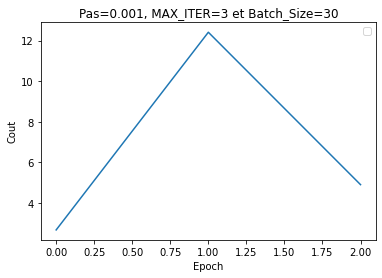

In [60]:
plot_loss(train_loss, title = "Pas="+str(LEARNING_RATE)+", MAX_ITER="+str(MAX_ITER)+" et Batch_Size="+str(BATCH_SIZE))

In [62]:
pred_y_cnn = predictCNN(optimCNN.net, X_te)
print(classification_report(y_te, pred_y_cnn))

              precision    recall  f1-score   support

           0       0.52      0.85      0.65       359
           1       0.97      0.95      0.96       264
           2       0.52      0.46      0.49       198
           3       0.55      0.50      0.52       166
           4       0.55      0.47      0.51       200
           5       0.54      0.36      0.43       160
           6       0.61      0.52      0.57       170
           7       0.56      0.63      0.59       147
           8       0.50      0.23      0.32       166
           9       0.49      0.49      0.49       177

    accuracy                           0.59      2007
   macro avg       0.58      0.55      0.55      2007
weighted avg       0.59      0.59      0.58      2007



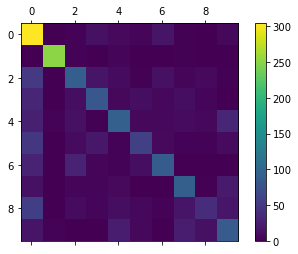

In [63]:
  
figure = plt.figure()
axes = figure.add_subplot(111)
  
# using the matshow() function 
caxes = axes.matshow(confusion_matrix(y_te, pred_y_cnn), interpolation ='nearest')
figure.colorbar(caxes)

plt.savefig("../matrice_conf_CNN.jpg")
plt.show()

In [64]:
# avec des données bruitées
data_noisy = X_te + 0.4 * np.random.randn(X_te.shape[0], X_te.shape[1])
pred_y_cnn_noisy = predictCNN(optimCNN.net, data_noisy)
print(classification_report(y_te, pred_y_cnn_noisy))

              precision    recall  f1-score   support

           0       0.47      0.30      0.37       359
           1       0.00      0.00      0.00       264
           2       0.19      0.53      0.28       198
           3       0.23      0.54      0.32       166
           4       0.28      0.53      0.37       200
           5       0.31      0.31      0.31       160
           6       0.31      0.08      0.12       170
           7       0.34      0.34      0.34       147
           8       0.26      0.06      0.10       166
           9       0.20      0.08      0.11       177

    accuracy                           0.27      2007
   macro avg       0.26      0.28      0.23      2007
weighted avg       0.27      0.27      0.23      2007

/home/margaal/Documents/ML/test/ml_projet/softmax.py:19: RuntimeWarning: overflow encountered in exp
  np.exp(X), np.transpose( np.tile(
/home/margaal/Documents/ML/test/ml_projet/softmax.py:20: RuntimeWarning: overflow encountered in exp
  n

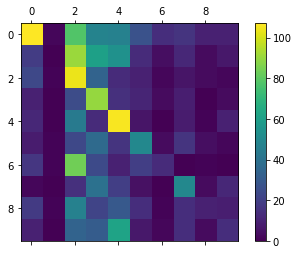

In [65]:
figure = plt.figure()
axes = figure.add_subplot(111)
  
# using the matshow() function 
caxes = axes.matshow(confusion_matrix(y_te, pred_y_cnn_noisy), interpolation ='nearest')
figure.colorbar(caxes)

plt.savefig("../matrice_conf_CNN_bruite.jpg")
plt.show()